In [1]:
import sys
import os
import math
import glob
import json

import argparse
import functools

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon, shape, Point, mapping
from shapely.ops import transform
import pyproj

import dask
import dask.dataframe as ddf
from dask.distributed import LocalCluster, Client

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm

from tqdm import tqdm

In [2]:
def get_conf(conf_path):
    with open(conf_path, 'r') as f:
        config = json.load(f)
    return config

In [4]:
# results_path = "../cell_stats/results_healpy/"
# config_path = '../cell_stats/config-healpy.json'
# default_name = 'cell_stats_healpy'

results_path = "../results_gen_bak/"
config_path = '../cell_stats/config-main1.json'
default_name = 'cell_stats_main'

sample_polygons = gpd.read_file('../cell_stats/sample_polygons.geojson',driver='GeoJSON')

config = get_conf(config_path)

In [5]:
config

{'dggss': [{'name': ['h3'],
   'global_res': [2, 3, 4, 5, 6],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['s2'],
   'global_res': [2, 3, 4, 5, 6, 7, 8, 9],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['rhpix'],
   'global_res': [2, 3, 4, 5, 6],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'ISEA7H'],
   'global_res': [2, 3, 4, 5, 6],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'FULLER7H'],
   'global_res': [2, 3, 4, 5, 6],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'ISEA4T'],
   'global_res': [2, 3, 4, 5, 6, 7, 8],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'FULLER4T'],
   'global_res': [2, 3, 4, 5, 6, 7, 8],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'ISEA4D'],
   'global_res': [2, 3, 4, 5, 6, 7, 8],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'FULLER4D'],
   'global_res': [2, 3, 4, 5, 6, 7, 8],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID

In [ ]:
def get_area_perimeter_from_lambert(geom):
    '''Area from cell's lambert azimutal projection'''
    perimeter = np.nan
    area = np.nan
    try:
        if (-180 <= geom.centroid.x <= 180) and (-90 <= geom.centroid.y <= 90):
            proj_str = f"+proj=laea +lat_0={geom.centroid.y} +lon_0={geom.centroid.x}"
            project = pyproj.Transformer.from_crs('EPSG:4236', proj_str, always_xy=True).transform
            perimeter = transform(project, geom).length
            area = transform(project, geom).area
        else:
            # print(f'invalid centroid {geom.centroid}')
            pass
    except Exception as ex:
        print(f'invalid centroid Exception')
        print(ex)
    # return (area, perimeter)
    return pd.Series([area, perimeter])

In [ ]:
sample_polygons[['area', 'perimeter']] = sample_polygons['geometry'].apply(get_area_perimeter_from_lambert)

# for the normalised area
sample_polygons['norm_area'] = sample_polygons['area']/sample_polygons['area'].mean()

In [ ]:
[print( f"{idx}: {name['name']}") for (idx, name) in enumerate(config['dggss'])]

In [ ]:
# world_countries NaturalEarth\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp
world_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# vmin, vmax, vcenter = 0.5, 1.3, 1
# norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# vmin, vmax, vcenter = sample_polygons['norm_area'].min(), sample_polygons['norm_area'].max(), 1
# norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

sample_polygons.to_crs('proj=moll').plot(column='norm_area', ax=ax, legend=True,cax=cax, cmap='RdYlBu_r', legend_kwds={'label': "sample locations",'orientation': "horizontal"})

world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "sample locations area",fontsize=14)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
# plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_area_map.png', bbox_inches="tight",dpi=300)



In [21]:
counter = 0
counter_step2 = 0
found_files = []
found_step2_files = []

potential_files = []

for dggs in config['dggss']:
    for res in dggs['global_res']:
        
        params = [dggs['name'], res, dggs['proj'], None]
        d_name, res, p_name = params[0], params[1], params[2]

        name = d_name[0]
        if len(d_name) > 1:
            name = '_'.join(d_name)

        potential_files.append(f"{name}_{res}")
        name = f"{name}_{res}_{p_name}"
        
        parquet_file_name = os.path.join(results_path, f"{name}.parquet")
        

        if os.path.exists(parquet_file_name):
            # print(f"{parquet_file_name} file exists, ok")
            counter = counter + 1
            found_files.append(parquet_file_name)
        else:
            print(f"{parquet_file_name} file MISSING")
        
        fgb_file_name = os.path.join(results_path, f"{name}_step2.fgb")
        
        if os.path.exists(fgb_file_name):
            # print(f"{fgb_file_name} file exists, ok")
            counter_step2 = counter + 1
            found_step2_files.append(parquet_file_name)
        else:
            print(f"{fgb_file_name} file MISSING")
    
    for res in dggs['sample_res']:
        
        params = [dggs['name'], res, dggs['proj'], None]
        d_name, res, p_name = params[0], params[1], params[2]

        for idx, row in sample_polygons.iterrows():
            name = d_name[0]
            if len(d_name) > 1:
                name = '_'.join(d_name)

            name = f"{name}_{res}_{p_name}_sample_id_{idx}"
            parquet_file_name = os.path.join(results_path, f"{name}.parquet")

            if os.path.exists(parquet_file_name):
                # print(f"{parquet_file_name} file exists, ok")
                counter = counter + 1
                found_files.append(parquet_file_name)
            else:
                print(f"{parquet_file_name} file MISSING")


assert(len(set(found_files)) == counter)

import glob

all_parquet = glob.glob(os.path.join(results_path, "*.parquet"))
all_count = len(all_parquet)

print(f"{counter} config based parquet files (vs {all_count}) glob")

diff = set(all_parquet).difference(set(found_files))

all_step2 = glob.glob(os.path.join(results_path, "*_step2.fgb"))
all_count_step2 = len(all_step2)

print(f"{counter_step2} config based step2 files (vs {all_count_step2}) glob")

diff_step2 = set(all_step2).difference(set(found_step2_files))

../results_gen_bak/h3_2_LAEA.parquet file MISSING
../results_gen_bak/h3_2_LAEA_step2.fgb file MISSING
../results_gen_bak/h3_3_LAEA.parquet file MISSING
../results_gen_bak/h3_3_LAEA_step2.fgb file MISSING
../results_gen_bak/h3_4_LAEA.parquet file MISSING
../results_gen_bak/h3_4_LAEA_step2.fgb file MISSING
../results_gen_bak/h3_5_LAEA.parquet file MISSING
../results_gen_bak/h3_5_LAEA_step2.fgb file MISSING
../results_gen_bak/h3_6_LAEA.parquet file MISSING
../results_gen_bak/h3_6_LAEA_step2.fgb file MISSING
../results_gen_bak/s2_2_LAEA.parquet file MISSING
../results_gen_bak/s2_2_LAEA_step2.fgb file MISSING
../results_gen_bak/s2_3_LAEA.parquet file MISSING
../results_gen_bak/s2_3_LAEA_step2.fgb file MISSING
../results_gen_bak/s2_4_LAEA.parquet file MISSING
../results_gen_bak/s2_4_LAEA_step2.fgb file MISSING
../results_gen_bak/s2_5_LAEA.parquet file MISSING
../results_gen_bak/s2_5_LAEA_step2.fgb file MISSING
../results_gen_bak/s2_6_LAEA.parquet file MISSING
../results_gen_bak/s2_6_LAEA_ste

In [22]:
found_files


[]

In [23]:
potential_files[0]

'h3_2'

In [7]:
quick_stats_fgb = []

for parquet_file_name in tqdm(found_files):
    
    fgb_file_name = parquet_file_name.replace(".parquet", "_step2.fgb")
    if os.path.isfile(fgb_file_name):
        df = gpd.read_file(fgb_file_name)
        rows = len(df.index)
        size = os.stat(fgb_file_name).st_size
        # print(f"{parquet_file_name} {rows}")
        quick_stats_fgb.append( (fgb_file_name.replace(results_path, ''), rows, size) )

qs = pd.DataFrame(quick_stats_fgb, columns=['filename', 'num_rows', 'filesize'])

qs.sort_values(by='filename').to_csv(results_path + 'quick_stats_fgb.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:08<00:00,  9.78s/it]


In [8]:
qs = pd.read_csv(results_path + 'quick_stats_fgb.csv')

qs.sort_values(by=['num_rows'], ascending=False).head(15)

,filename,num_rows,filesize
6,healpy_8_LAEA_step2.fgb,786432,197133168
5,healpy_7_LAEA_step2.fgb,196608,49283976
4,healpy_6_LAEA_step2.fgb,49152,12321648
3,healpy_5_LAEA_step2.fgb,12288,3081096
2,healpy_4_LAEA_step2.fgb,3072,770928
1,healpy_3_LAEA_step2.fgb,768,193416
0,healpy_2_LAEA_step2.fgb,192,49008


In [9]:
def get_cells_area_stats(df):
    
    # Filter out invalid geometry
    try:
        # df['crossed'] = df['geometry'].apply(check_for_geom)
        date_line_cross_error_cells = len(df[df['crossed']])
        df = df[~df['crossed']]
        
        other_geom_anomalies = len(df[(df['area']<df['area'].quantile(0.005))&(df['area']>df['area'].quantile(0.995))])
        df = df[(df['area']>df['area'].quantile(0.005))&(df['area']<df['area'].quantile(0.995))]
        df['area'] = df['area'] / 1000000
        df['norm_area'] = df['area']/df['area'].mean()
        
        area_min = df['area'].min()
        area_max = df['area'].max()
        area_std = df['area'].std()
        area_mean = df['area'].mean()
        area_median = df['area'].median()
        
        ipq_min = df['ipq'].min()
        ipq_max = df['ipq'].max()
        ipq_std = df['ipq'].std()
        ipq_mean = df['ipq'].mean()
        ipq_median = df['ipq'].median()
        
        perimeter_min = df['perimeter'].min()
        perimeter_max = df['perimeter'].max()
        perimeter_std = df['perimeter'].std()
        perimeter_mean = df['perimeter'].mean()
        perimeter_median = df['perimeter'].median()
        
        norm_area_min = df['norm_area'].min()
        norm_area_max = df['norm_area'].max()
        norm_area_std = df['norm_area'].std()
        norm_area_mean = df['norm_area'].mean()
        norm_area_median = df['norm_area'].median()
        
        num_cells = len(df)
        
        stats_pd = pd.DataFrame({'area_min':[area_min],'area_max':[area_max], 'area_std':[area_std],'area_mean':[area_mean],'area_median':[area_median],
                                'ipq_min':[ipq_min],'ipq_max':[ipq_max], 'ipq_std':[ipq_std],'ipq_mean':[ipq_mean],'ipq_median':[ipq_median],
                                'perimeter_min':[perimeter_min],'perimeter_max':[perimeter_max], 'perimeter_std':[perimeter_std],'perimeter_mean':[perimeter_mean],'perimeter_median':[perimeter_median],
                                'norm_area_min':[norm_area_min],'norm_area_max':[norm_area_max], 'norm_area_std':[norm_area_std],'norm_area_mean':[norm_area_mean],'norm_area_median':[norm_area_median],
                                'num_cells':[num_cells], 'date_line_cross_error_cells':[date_line_cross_error_cells],'other_geom_anomalies':other_geom_anomalies})
    
        return stats_pd
    except Exception as ex:
        print(ex)
        print(len(df))
        return None

In [3]:
# filename = "DGGRID_ISEA4T_8_LAEA_step2.fgb"
# filename = "h3_5_LAEA_step2.fgb"
filename = "healpy_8_LAEA_step2.fgb"

def csv_fname(filename):
    tx = filename.split("_")
    nums = len(tx)
    baset = "_".join(tx[:-3])
    fname = f"{baset}_{tx[-3]}_stats.csv"

    return (fname, baset, tx[-3])

csv_fname(filename)

('healpy_8_stats.csv', 'healpy', '8')

In [13]:
done_files = []
    
for idx, row in qs.loc[qs["num_rows"] < 400000].iterrows():
# for idx, row in qs.loc[qs["num_rows"] > 400000].iterrows():
    fname = results_path + row["filename"]
    df = gpd.read_file(fname)
    results = get_cells_area_stats(df)
    outfile, baset, res = csv_fname(row["filename"])
    results['baset'] = baset
    results['res'] = res
    results.to_csv(results_path + outfile, index=False)
    print(f"{baset} {res} stats")
    done_files.append(outfile)

healpy 8 stats


In [24]:
results_path = "../results_gen_bak/"

In [25]:
# done_files = list(map(lambda fn: csv_fname(fn)[0], qs.filename))

In [27]:
done_files = []

for fn in potential_files:
    stats_csv_fn = fn + "_stats.csv"
    if os.path.isfile(os.path.join(results_path, stats_csv_fn)):
        done_files.append(stats_csv_fn)
    else:
        print(f"not here? ({stats_csv_fn})")

not here? (h3_5_stats.csv)
not here? (h3_6_stats.csv)
not here? (s2_9_stats.csv)
not here? (rhpix_6_stats.csv)
not here? (DGGRID_ISEA7H_6_stats.csv)
not here? (DGGRID_FULLER7H_6_stats.csv)
not here? (DGGRID_ISEA4T_8_stats.csv)
not here? (DGGRID_FULLER4T_8_stats.csv)
not here? (DGGRID_ISEA4D_8_stats.csv)
not here? (DGGRID_FULLER4D_8_stats.csv)
not here? (eaggr_ISEA4T_8_stats.csv)
not here? (eaggr_ISEA3H_6_stats.csv)


In [ ]:
done_files

In [29]:
all_stats = []

def mini_split(baset):
    tx = baset.split("_")
    baset = "_".join(tx[:-1])
    res = tx[-1]

    return pd.Series([baset, res])

for fn in done_files:
    fname = fn.replace("_LAEA", "")
    df = pd.read_csv(results_path + fname)
    # df[["baset", "res"]] = df["baset"].apply(mini_split)
    all_stats.append(df)

all_df = pd.concat(all_stats, axis=0).reset_index(drop=True)

In [30]:
all_df

,area_min,area_max,area_std,area_mean,area_median,ipq_min,ipq_max,ipq_std,ipq_mean,ipq_median,...,norm_area_min,norm_area_max,norm_area_std,norm_area_mean,norm_area_median,num_cells,date_line_cross_error_cells,other_geom_anomalies,baset,res
0,5.656740e+04,1.046511e+05,11294.916325,8.683802e+04,8.847602e+04,0.891926,0.906898,0.002867,0.904700,0.905816,...,0.651413,1.205130,0.130069,1.0,1.018863,5736,88,0,h3,2
1,8.032047e+03,1.494577e+04,1618.709340,1.240370e+04,1.261228e+04,0.882808,0.910977,0.003054,0.904727,0.905856,...,0.647552,1.204945,0.130502,1.0,1.016815,40534,218,0,h3,3
2,1.146819e+03,2.135048e+03,231.371148,1.771858e+03,1.800565e+03,0.891493,0.906900,0.002805,0.904715,0.905795,...,0.647241,1.204977,0.130581,1.0,1.016202,284649,597,0,h3,4
3,4.834717e+06,5.961481e+06,389927.636908,5.185449e+06,5.066762e+06,0.745612,0.784003,0.013760,0.767413,0.771650,...,0.932362,1.149656,0.075197,1.0,0.977112,85,9,0,s2,2
4,1.050416e+06,1.649453e+06,181663.685105,1.322308e+06,1.358029e+06,0.716118,0.785322,0.016869,0.767050,0.771155,...,0.794381,1.247404,0.137384,1.0,1.027015,364,16,0,s2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1.637886e+05,1.683147e+05,755.482317,1.659714e+05,1.658086e+05,0.605516,0.785277,0.046223,0.748478,0.774370,...,0.986848,1.014119,0.004552,1.0,0.999019,2977,63,0,healpy,4
69,4.125909e+04,4.197782e+04,165.647552,4.150346e+04,4.145410e+04,0.596217,0.785398,0.047002,0.748243,0.774338,...,0.994112,1.011429,0.003991,1.0,0.998811,12039,127,0,healpy,5
70,1.032825e+04,1.047315e+04,41.162675,1.037668e+04,1.036442e+04,0.591701,0.785398,0.047384,0.747822,0.774330,...,0.995332,1.009297,0.003967,1.0,0.998818,48407,255,0,healpy,6
71,2.582048e+03,2.617363e+03,10.327374,2.594239e+03,2.591387e+03,0.589477,0.785398,0.047703,0.747659,0.774275,...,0.995301,1.008913,0.003981,1.0,0.998901,194135,511,0,healpy,7


In [31]:
all_df.to_csv(results_path + "all_dggs_stats.csv", index=False)

In [32]:
all_df = pd.read_csv(results_path + "all_dggs_stats.csv")
all_df.head(3)

,area_min,area_max,area_std,area_mean,area_median,ipq_min,ipq_max,ipq_std,ipq_mean,ipq_median,...,norm_area_min,norm_area_max,norm_area_std,norm_area_mean,norm_area_median,num_cells,date_line_cross_error_cells,other_geom_anomalies,baset,res
0,56567.396509,104651.091369,11294.916325,86838.015747,88476.023102,0.891926,0.906898,0.002867,0.904700,0.905816,...,0.651413,1.205130,0.130069,1.0,1.018863,5736,88,0,h3,2
1,8032.046526,14945.774889,1618.709340,12403.702736,12612.276631,0.882808,0.910977,0.003054,0.904727,0.905856,...,0.647552,1.204945,0.130502,1.0,1.016815,40534,218,0,h3,3
2,1146.819110,2135.048421,231.371148,1771.857594,1800.565342,0.891493,0.906900,0.002805,0.904715,0.905795,...,0.647241,1.204977,0.130581,1.0,1.016202,284649,597,0,h3,4


In [33]:
display(all_df["baset"].unique())

paper_df = all_df.loc[all_df["baset"].isin([ 'h3', 's2', 'eaggr_ISEA4T', 'rhpix', 'healpy',
                                            'DGGRID_ISEA7H', 'DGGRID_FULLER7H', 'DGGRID_ISEA4D', 'DGGRID_FULLER4D', 'DGGRID_ISEA4T', 'DGGRID_FULLER4T' ]) ]

array(['h3', 's2', 'rhpix', 'DGGRID_ISEA7H', 'DGGRID_FULLER7H',
       'DGGRID_ISEA4T', 'DGGRID_FULLER4T', 'DGGRID_ISEA4D',
       'DGGRID_FULLER4D', 'DGGRID_ISEA3H', 'DGGRID_FULLER3H',
       'eaggr_ISEA4T', 'eaggr_ISEA3H', 'healpy'], dtype=object)

<Axes: xlabel='res', ylabel='ipq_median'>

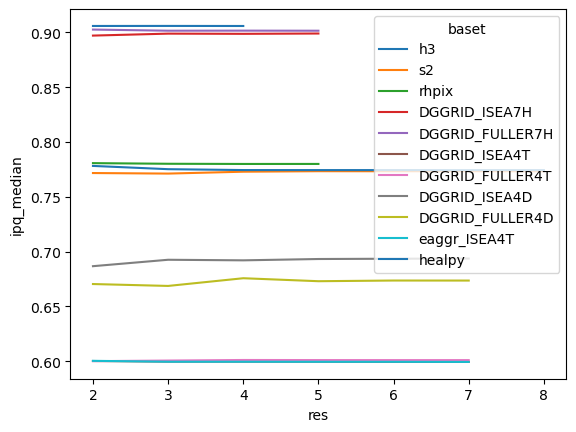

In [34]:
import seaborn as sns

sns.lineplot(data=paper_df, x="res", y="ipq_median", hue="baset", palette="tab10")

<Axes: xlabel='res', ylabel='ipq_mean'>

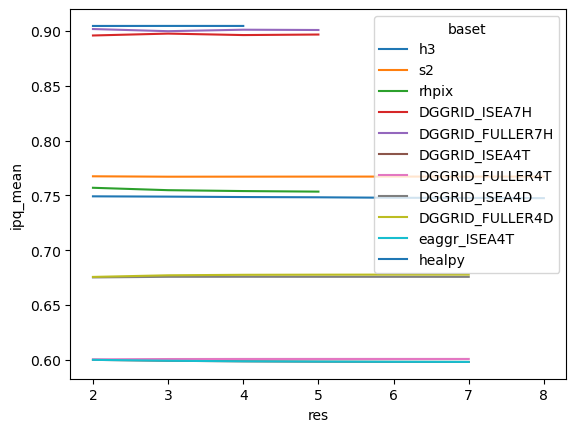

In [35]:
sns.lineplot(data=paper_df, x="res", y="ipq_mean", hue="baset", palette="tab10")

<Axes: xlabel='res', ylabel='ipq_std'>

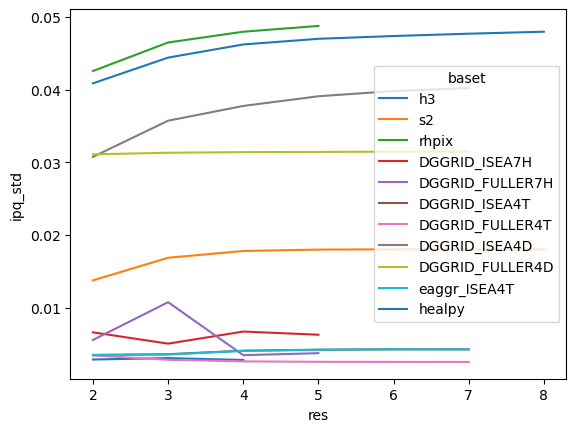

In [36]:
sns.lineplot(data=paper_df, x="res", y="ipq_std", hue="baset", palette="tab10")

<Axes: xlabel='res', ylabel='norm_area_median'>

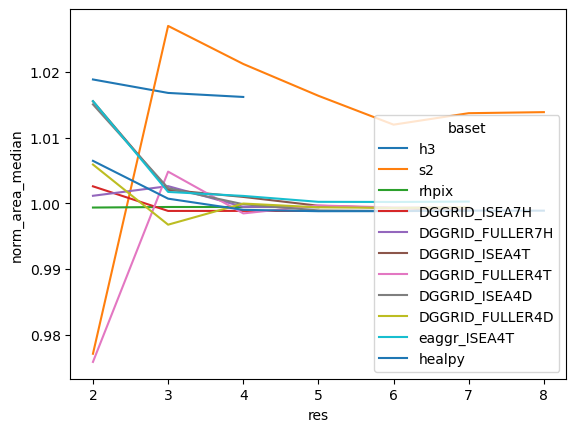

In [37]:
sns.lineplot(data=paper_df, x="res", y="norm_area_median", hue="baset", palette="tab10")

<Axes: xlabel='area_mean', ylabel='norm_area_std'>

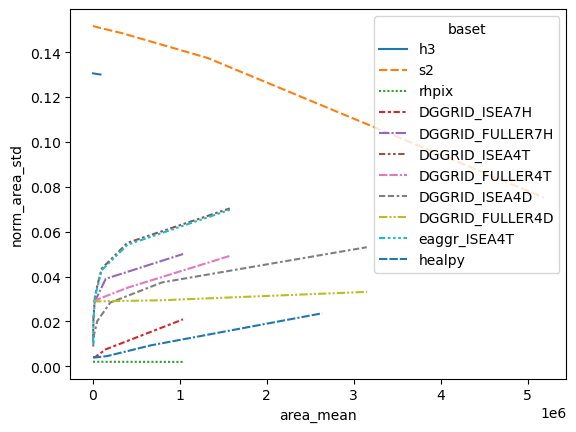

In [38]:
sns.lineplot(data=paper_df, x="area_mean", y="norm_area_std", hue="baset", style="baset", palette="tab10")

<Axes: xlabel='res', ylabel='area_mean'>

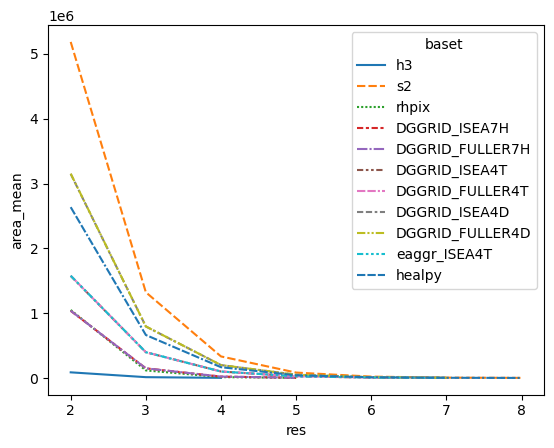

In [39]:
sns.lineplot(data=paper_df, x="res", y="area_mean", hue="baset", style="baset", palette="tab10")

In [40]:
tri = all_df.loc[all_df["baset"].isin(['DGGRID_FULLER3H', 'DGGRID_FULLER4T','DGGRID_ISEA3H', 'DGGRID_ISEA4T', 'eaggr_ISEA3H', 'eaggr_ISEA4T'])]
# tri = all_df.loc[all_df["baset"].isin(['healpy'])]

In [41]:
tri.groupby("baset").agg("mean")

,area_min,area_max,area_std,area_mean,area_median,ipq_min,ipq_max,ipq_std,ipq_mean,ipq_median,...,perimeter_median,norm_area_min,norm_area_max,norm_area_std,norm_area_mean,norm_area_median,num_cells,date_line_cross_error_cells,other_geom_anomalies,res
baset,,,,,,,,,,,,,,,,,,,,,
DGGRID_FULLER3H,1.229527e+06,1.773709e+06,134515.243423,1.663619e+06,1.697926e+06,0.875272,0.906384,0.006255,0.900803,0.902544,...,3.938256e+06,0.811642,1.059224,0.049104,1.0,1.008208,2118.000000,38.8,0.0,4.0
DGGRID_FULLER4T,3.260805e+05,3.786048e+05,15921.540706,3.510853e+05,3.450366e+05,0.592657,0.604598,0.002747,0.600559,0.600789,...,1.878660e+06,0.930571,1.064598,0.033668,1.0,0.996263,71823.333333,250.0,0.0,4.5
DGGRID_ISEA3H,1.375725e+06,1.714183e+06,81871.634706,1.659985e+06,1.691583e+06,0.873454,0.903762,0.006703,0.897187,0.899753,...,3.941003e+06,0.884101,1.021575,0.025995,1.0,1.006460,2116.000000,40.8,0.0,4.0
DGGRID_ISEA4T,3.006773e+05,3.907260e+05,22997.485713,3.507764e+05,3.550069e+05,0.585872,0.604600,0.003988,0.598567,0.599624,...,1.897085e+06,0.852162,1.139718,0.038936,1.0,1.002741,71823.333333,250.0,0.0,4.5
eaggr_ISEA3H,2.033930e+06,2.115421e+06,12442.961684,2.097867e+06,2.101090e+06,0.381778,0.903094,0.055490,0.874001,0.891599,...,4.700949e+06,0.978778,1.009133,0.003808,1.0,1.000797,94545.250000,2345.5,0.0,3.5
eaggr_ISEA4T,3.015753e+05,3.890098e+05,22803.072386,3.511941e+05,3.554221e+05,0.586497,0.604598,0.003968,0.598579,0.599605,...,1.898130e+06,0.853739,1.138007,0.038170,1.0,1.003196,71741.000000,333.0,0.0,4.5


In [42]:
paper_df.groupby("baset").agg("mean")

,area_min,area_max,area_std,area_mean,area_median,ipq_min,ipq_max,ipq_std,ipq_mean,ipq_median,...,perimeter_median,norm_area_min,norm_area_max,norm_area_std,norm_area_mean,norm_area_median,num_cells,date_line_cross_error_cells,other_geom_anomalies,res
baset,,,,,,,,,,,,,,,,,,,,,
DGGRID_FULLER4D,651812.416946,7.384486e+05,22604.791844,702044.068866,704715.100610,0.629680,0.742290,0.031368,0.677153,0.672477,...,2.530804e+06,0.930831,1.054868,0.029735,1.0,1.000126,35903.000000,133.333333,0.0,4.5
DGGRID_FULLER4T,326080.536394,3.786048e+05,15921.540706,351085.301894,345036.555930,0.592657,0.604598,0.002747,0.600559,0.600789,...,1.878660e+06,0.930571,1.064598,0.033668,1.0,0.996263,71823.333333,250.000000,0.0,4.5
DGGRID_FULLER7H,213564.810870,3.194233e+05,14598.051923,302448.081842,302842.510142,0.861890,0.906672,0.005879,0.901017,0.901764,...,1.499770e+06,0.836437,1.056926,0.036734,1.0,1.000670,48341.250000,171.250000,0.0,3.5
DGGRID_ISEA4D,623232.974568,7.508627e+05,33951.162071,701370.099022,709571.734502,0.596411,0.725054,0.037230,0.675547,0.691927,...,2.488773e+06,0.894891,1.078243,0.026962,1.0,1.002315,35903.000000,133.333333,0.0,4.5
DGGRID_ISEA4T,300677.307812,3.907260e+05,22997.485713,350776.371074,355006.927937,0.585872,0.604600,0.003988,0.598567,0.599624,...,1.897085e+06,0.852162,1.139718,0.038936,1.0,1.002741,71823.333333,250.000000,0.0,4.5
DGGRID_ISEA7H,263008.079827,3.069364e+05,5718.946770,302217.234927,302840.574326,0.877847,0.904428,0.006161,0.896739,0.898355,...,1.502123e+06,0.950849,1.017353,0.009178,1.0,0.999789,48340.250000,171.750000,0.0,3.5
eaggr_ISEA4T,301575.257943,3.890098e+05,22803.072386,351194.143085,355422.104261,0.586497,0.604598,0.003968,0.598579,0.599605,...,1.898130e+06,0.853739,1.138007,0.038170,1.0,1.003196,71741.000000,333.000000,0.0,4.5
h3,21915.420715,4.057730e+04,4381.665604,33671.192026,34296.288358,0.888742,0.908258,0.002909,0.904714,0.905822,...,5.614112e+05,0.648735,1.205017,0.130384,1.0,1.017293,110306.333333,301.000000,0.0,3.0
healpy,463030.522901,5.122020e+05,9908.693605,502817.348334,505291.568123,0.609154,0.785241,0.045940,0.748237,0.774989,...,1.860234e+06,0.970750,1.012572,0.007626,1.0,1.000234,148002.142857,289.285714,0.0,5.0


In [43]:
for idx, group in paper_df[['baset',
          'res',
          'num_cells',
          'area_std',
 'area_mean',
 'area_median',

           'norm_area_mean',
           'norm_area_median',
             'norm_area_min',
             'norm_area_max',
             'norm_area_std',
 'ipq_mean',
 'ipq_median',
 'date_line_cross_error_cells',
 'other_geom_anomalies'
]].groupby("baset"):
    display(group.sort_values(by=["res"]))

,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
40,DGGRID_FULLER4D,2,146,104557.013915,3.152696e+06,3.171343e+06,1.0,1.005915,0.929321,1.051575,0.033164,0.675545,0.670393,12,0
41,DGGRID_FULLER4D,3,608,23400.972459,7.950335e+05,7.924575e+05,1.0,0.996760,0.924842,1.051446,0.029434,0.677023,0.668661,24,0
42,DGGRID_FULLER4D,4,2484,5778.560113,1.991575e+05,1.991528e+05,1.0,0.999976,0.927306,1.056366,0.029015,0.677465,0.675689,50,0
43,DGGRID_FULLER4D,5,10036,1441.882847,4.981085e+04,4.978098e+04,1.0,0.999401,0.933402,1.056631,0.028947,0.677577,0.672969,102,0
44,DGGRID_FULLER4D,6,40348,360.277521,1.245358e+04,1.244505e+04,1.0,0.999316,0.935045,1.056570,0.028930,0.677643,0.673591,204,0
45,DGGRID_FULLER4D,7,161796,90.044206,3.113405e+03,3.111504e+03,1.0,0.999389,0.935069,1.056624,0.028921,0.677662,0.673560,408,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
28,DGGRID_FULLER4T,2,294,77622.141525,1.576768e+06,1.538719e+06,1.0,0.975869,0.929784,1.081300,0.049229,0.600257,0.600034,22,0
29,DGGRID_FULLER4T,3,1220,13914.062358,3.974833e+05,3.994051e+05,1.0,1.004835,0.924873,1.072528,0.035005,0.600554,0.600595,46,0
30,DGGRID_FULLER4T,4,4974,3037.350254,9.957219e+04,9.942041e+04,1.0,0.998476,0.927011,1.062364,0.030504,0.600626,0.601106,94,0
31,DGGRID_FULLER4T,5,20086,729.945240,2.490459e+04,2.489669e+04,1.0,0.999683,0.932890,1.058127,0.029310,0.600639,0.601024,190,0
32,DGGRID_FULLER4T,6,80722,180.687107,6.226707e+03,6.222838e+03,1.0,0.999379,0.933828,1.056629,0.029018,0.600639,0.600991,382,0
33,DGGRID_FULLER4T,7,323644,45.057754,1.556694e+03,1.555665e+03,1.0,0.999339,0.935043,1.056640,0.028945,0.600638,0.600987,766,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
18,DGGRID_FULLER7H,2,462,51907.415570,1.037238e+06,1.038440e+06,1.0,1.001158,0.688888,1.055743,0.050044,0.901878,0.902531,24,0
19,DGGRID_FULLER7H,3,3335,5783.807808,1.482723e+05,1.486615e+05,1.0,1.002625,0.789123,1.058740,0.039008,0.899921,0.901495,63,0
20,DGGRID_FULLER7H,4,23612,612.851246,2.124683e+04,2.123568e+04,1.0,0.999475,0.935888,1.056513,0.028844,0.901269,0.901551,160,0
21,DGGRID_FULLER7H,5,165956,88.133068,3.034857e+03,3.033099e+03,1.0,0.999420,0.931849,1.056707,0.029040,0.901001,0.901478,438,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
34,DGGRID_ISEA4D,2,146,167141.884251,3.149036e+06,3.196493e+06,1.0,1.015070,0.895837,1.067532,0.053077,0.675078,0.686678,12,0
35,DGGRID_ISEA4D,3,608,29706.478657,7.946605e+05,7.965104e+05,1.0,1.002328,0.866184,1.078583,0.037383,0.675649,0.692535,24,0
36,DGGRID_ISEA4D,4,2484,5653.164395,1.991504e+05,1.991246e+05,1.0,0.999870,0.854202,1.082851,0.028386,0.675671,0.692009,50,0
37,DGGRID_ISEA4D,5,10036,1003.665197,4.980779e+04,4.975442e+04,1.0,0.998929,0.916622,1.082495,0.020151,0.675647,0.693220,102,0
38,DGGRID_ISEA4D,6,40348,174.510890,1.245249e+04,1.243814e+04,1.0,0.998847,0.916993,1.079986,0.014014,0.675633,0.693481,204,0
39,DGGRID_ISEA4D,7,161796,27.269034,3.113183e+03,3.109597e+03,1.0,0.998848,0.919510,1.078014,0.008759,0.675603,0.693636,408,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
22,DGGRID_ISEA4T,2,294,110859.846411,1.575240e+06,1.599721e+06,1.0,1.015542,0.855427,1.106608,0.070377,0.599818,0.600177,22,0
23,DGGRID_ISEA4T,3,1220,21855.291924,3.971944e+05,3.980131e+05,1.0,1.002061,0.866426,1.132226,0.055024,0.598976,0.599634,46,0
24,DGGRID_ISEA4T,4,4974,4327.117192,9.954114e+04,9.963915e+04,1.0,1.000985,0.851288,1.143694,0.043471,0.598478,0.599611,94,0
25,DGGRID_ISEA4T,5,20086,791.540274,2.490049e+04,2.489154e+04,1.0,0.999641,0.847412,1.150637,0.031788,0.598192,0.599554,190,0
26,DGGRID_ISEA4T,6,80722,133.093598,6.226032e+03,6.221631e+03,1.0,0.999293,0.845498,1.153261,0.021377,0.598016,0.599421,382,0
27,DGGRID_ISEA4T,7,323644,18.024878,1.556574e+03,1.554901e+03,1.0,0.998925,0.846921,1.151882,0.011580,0.597921,0.599346,766,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
14,DGGRID_ISEA7H,2,462,21654.062257,1.035883e+06,1.038575e+06,1.0,1.002599,0.852654,1.014005,0.020904,0.895997,0.897037,24,0
15,DGGRID_ISEA7H,3,3334,1124.182018,1.487087e+05,1.485379e+05,1.0,0.998852,0.972798,1.027720,0.007560,0.897712,0.898818,63,0
16,DGGRID_ISEA7H,4,23608,84.594020,2.124257e+04,2.121829e+04,1.0,0.998857,0.995000,1.008968,0.003982,0.896382,0.898638,164,0
17,DGGRID_ISEA7H,5,165957,12.948783,3.034835e+03,3.031344e+03,1.0,0.998850,0.982945,1.018719,0.004267,0.896866,0.898926,436,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
56,eaggr_ISEA4T,2,287,110115.033716,1.577465e+06,1.602018e+06,1.0,1.015565,0.856293,1.099423,0.069805,0.599829,0.600329,29,0
57,eaggr_ISEA4T,3,1205,21528.465398,3.974492e+05,3.981428e+05,1.0,1.001745,0.870100,1.127893,0.054167,0.598998,0.599533,61,0
58,eaggr_ISEA4T,4,4945,4256.095668,9.956569e+04,9.967897e+04,1.0,1.001138,0.855059,1.143380,0.042747,0.598486,0.599517,125,0
59,eaggr_ISEA4T,5,20023,773.699887,2.490207e+04,2.490799e+04,1.0,1.000238,0.848952,1.150756,0.031070,0.598204,0.599469,253,0
60,eaggr_ISEA4T,6,80595,128.698082,6.226205e+03,6.227546e+03,1.0,1.000215,0.845825,1.154141,0.020670,0.598024,0.599443,509,0
61,eaggr_ISEA4T,7,323391,16.441567,1.556589e+03,1.557019e+03,1.0,1.000276,0.846201,1.152450,0.010563,0.597929,0.599340,1021,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
0,h3,2,5736,11294.916325,86838.015747,88476.023102,1.0,1.018863,0.651413,1.205130,0.130069,0.904700,0.905816,88,0
1,h3,3,40534,1618.709340,12403.702736,12612.276631,1.0,1.016815,0.647552,1.204945,0.130502,0.904727,0.905856,218,0
2,h3,4,284649,231.371148,1771.857594,1800.565342,1.0,1.016202,0.647241,1.204977,0.130581,0.904715,0.905795,597,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
66,healpy,2,175,62221.113770,2.635607e+06,2.652677e+06,1.0,1.006477,0.917762,1.019932,0.023608,0.749122,0.778144,15,0
67,healpy,3,729,6164.534819,6.630203e+05,6.634976e+05,1.0,1.000720,0.910607,1.015411,0.009298,0.748855,0.775166,31,0
68,healpy,4,2977,755.482317,1.659714e+05,1.658086e+05,1.0,0.999019,0.986848,1.014119,0.004552,0.748478,0.774370,63,0
69,healpy,5,12039,165.647552,4.150346e+04,4.145410e+04,1.0,0.998811,0.994112,1.011429,0.003991,0.748243,0.774338,127,0
70,healpy,6,48407,41.162675,1.037668e+04,1.036442e+04,1.0,0.998818,0.995332,1.009297,0.003967,0.747822,0.774330,255,0
71,healpy,7,194135,10.327374,2.594239e+03,2.591387e+03,1.0,0.998901,0.995301,1.008913,0.003981,0.747659,0.774275,511,0
72,healpy,8,777553,2.586730,6.485652e+02,6.478463e+02,1.0,0.998892,0.995291,1.008900,0.003988,0.747476,0.774300,1023,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
10,rhpix,2,453,2028.506678,1.049384e+06,1.048721e+06,1.0,0.999368,0.997603,1.004870,0.001933,0.756932,0.780681,21,0
11,rhpix,3,4249,232.702613,1.166080e+05,1.165443e+05,1.0,0.999453,0.997526,1.004531,0.001996,0.754740,0.780107,75,0
12,rhpix,4,38731,26.066461,1.295674e+04,1.294959e+04,1.0,0.999448,0.997502,1.004516,0.002012,0.753935,0.779937,237,0
13,rhpix,5,349548,2.906651,1.439645e+03,1.438838e+03,1.0,0.999440,0.997495,1.004583,0.002019,0.753419,0.779952,486,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
3,s2,2,85,389927.636908,5.185449e+06,5.066762e+06,1.0,0.977112,0.932362,1.149656,0.075197,0.767413,0.771650,9,0
4,s2,3,364,181663.685105,1.322308e+06,1.358029e+06,1.0,1.027015,0.794381,1.247404,0.137384,0.767050,0.771155,16,0
5,s2,4,1487,49331.249543,3.321368e+05,3.391857e+05,1.0,1.021223,0.693559,1.244901,0.148527,0.767094,0.772866,33,0
6,s2,5,6017,12533.831828,8.309832e+04,8.445932e+04,1.0,1.016378,0.648826,1.258405,0.150831,0.767138,0.773325,65,0
7,s2,6,24201,3146.716707,2.077300e+04,2.102196e+04,1.0,1.011985,0.654022,1.256585,0.151481,0.767159,0.773277,129,0
8,s2,7,97065,787.526711,5.192471e+03,5.263767e+03,1.0,1.013731,0.651886,1.257662,0.151667,0.767165,0.773347,257,0
9,s2,8,388775,196.935359,1.297986e+03,1.316015e+03,1.0,1.013889,0.652659,1.257636,0.151724,0.767169,0.773297,513,0


In [44]:
s1 = list( map(lambda s: s.upper(), all_df["baset"].unique().tolist() ))
print(s1)
print( [ a for a,b in enumerate(s1)])

['H3', 'S2', 'RHPIX', 'DGGRID_ISEA7H', 'DGGRID_FULLER7H', 'DGGRID_ISEA4T', 'DGGRID_FULLER4T', 'DGGRID_ISEA4D', 'DGGRID_FULLER4D', 'DGGRID_ISEA3H', 'DGGRID_FULLER3H', 'EAGGR_ISEA4T', 'EAGGR_ISEA3H', 'HEALPY']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [52]:
print_data = [
 'DGGRID_FULLER3H_6_LAEA_step2.fgb',
 'DGGRID_FULLER4D_6_LAEA_step2.fgb', # (4,5?)
 'DGGRID_FULLER4T_5_LAEA_step2.fgb',
 'DGGRID_FULLER7H_4_LAEA_step2.fgb',
 'DGGRID_ISEA3H_6_LAEA_step2.fgb',
 'DGGRID_ISEA4D_6_LAEA_step2.fgb',
 'DGGRID_ISEA4T_5_LAEA_step2.fgb',
 'DGGRID_ISEA7H_4_LAEA_step2.fgb',
 # 'eaggr_ISEA3H_3_LAEA_step2.fgb', # (probably rubbish and duplicates)
 'eaggr_ISEA4T_5_LAEA_step2.fgb',
     'rhpix_4_LAEA_step2.fgb',
    'healpy_6_LAEA_step2.fgb',
 'h3_3_LAEA_step2.fgb',

 's2_6_LAEA_step2.fgb'
    
]

In [53]:
import requests

In [54]:
query_parameters = {"download": 1}

for fname in print_data:
    if os.path.isfile(results_path + fname):
        continue
    url = f"https://zenodo.org/records/6634479/files/{fname}"
    req = requests.get(url, params=query_parameters)
    with open(results_path + fname, mode="wb") as file:
        file.write(req.content)

In [57]:
data_box = []

for datafile in print_data:
    res = datafile.split("_")[-3]
    dggs = datafile.split("_")[:-3]
    grid = gpd.read_file(results_path + datafile)

    # remove bogus cells for nice plotting
    grid = grid[~grid['crossed']].dropna(subset=["perimeter", "area", "ipq"])
    # grid = grid[(grid['area']>grid['area'].quantile(0.001)) & (grid['area']<grid['area'].quantile(0.999))]
    
    # for the normalised area
    grid['norm_area'] = grid['area']/grid['area'].mean()
    
    df = grid[["area", "norm_area", "ipq"]].copy()
    df["res"] = int(res)
    dggs = ["RHEALPIX"] if "_".join(dggs) in "rhpix" else dggs
    df["dggs"] = ("_".join(dggs)).upper()
    data_box.append(df)

In [58]:
df = pd.concat(data_box, axis=0)
df.sample(5)

,area,norm_area,ipq,res,dggs
16412,2.584487e+10,1.037806,0.603223,5,DGGRID_FULLER4T
12979,2.075090e+10,0.976832,0.897684,4,DGGRID_FULLER7H
32111,1.293298e+10,0.998155,0.784579,4,RHEALPIX
29872,1.158761e+10,0.934976,0.904828,3,H3
13388,2.515275e+10,1.010129,0.595770,5,DGGRID_ISEA4T


In [59]:
df["dggs"] = df.dggs.apply(lambda s: s.replace("_", " "))

In [61]:
df["dggs"] = df.dggs.apply(lambda s: s.replace("HEALPY", "HEALPIX"))

/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_95683/2902176267.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_95683/2902176267.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.boxplot(x='dggs', y="norm_area", data=df, palette="viridis", saturation=0.9, showfliers=True, flierprops = outlier_design)


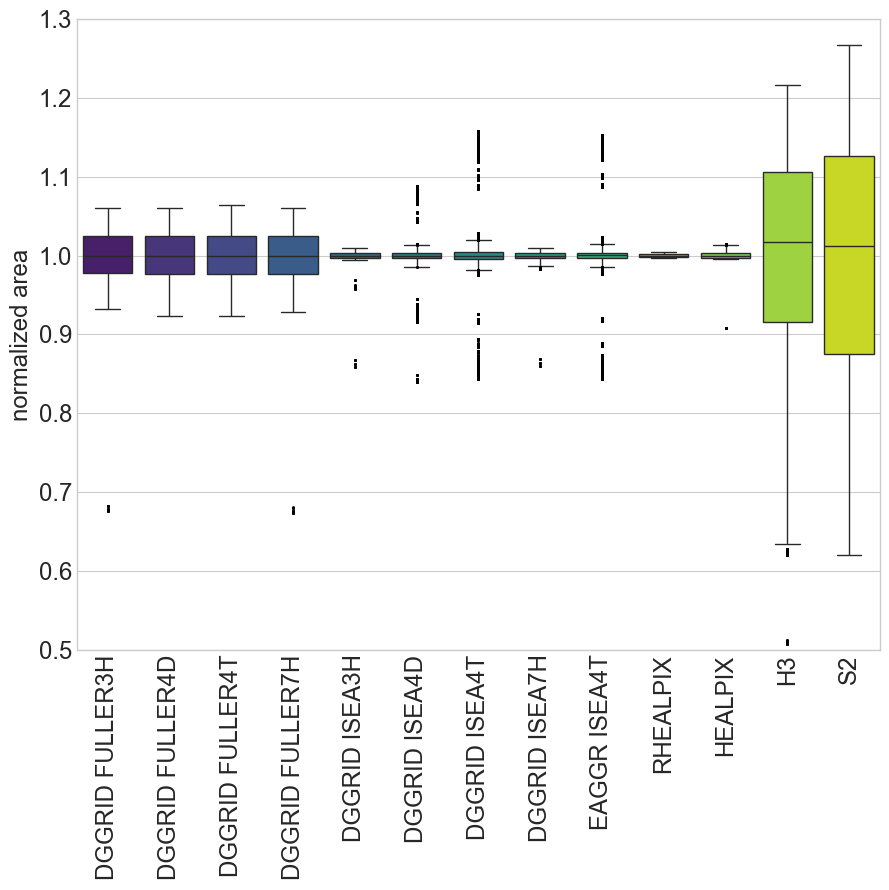

In [62]:
plt.figure(figsize=(9,9))
# fig, ax = plt.subplots(figsize=(10,5))

plt.style.use('seaborn-whitegrid')

#define design of the outliers
outlier_design = dict(marker='o', markerfacecolor='black', markersize=1,
                  linestyle='none', markeredgecolor='black')
#plot the boxplots
chart = sns.boxplot(x='dggs', y="norm_area", data=df, palette="viridis", saturation=0.9, showfliers=True, flierprops = outlier_design)

plt.xticks(
    rotation=90,
    horizontalalignment='center',
    fontweight='light',
    fontsize='xx-large', 
)

plt.xlabel('', fontsize='x-large')

plt.yticks(
    rotation=0, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='xx-large',
)

plt.ylabel('normalized area', fontsize='xx-large')

# plt.title("ASTER", fontsize='xx-large')

#set min and max values for y-axis
plt.ylim(0.5, 1.3)

plt.tight_layout()
plt.savefig(results_path + "box_plot_area.png", bbox_inches="tight",dpi=300)


/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_95683/677938929.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_95683/677938929.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.boxplot(x='dggs', y="ipq", data=df, palette="viridis", saturation=0.9, showfliers=True, flierprops = outlier_design)


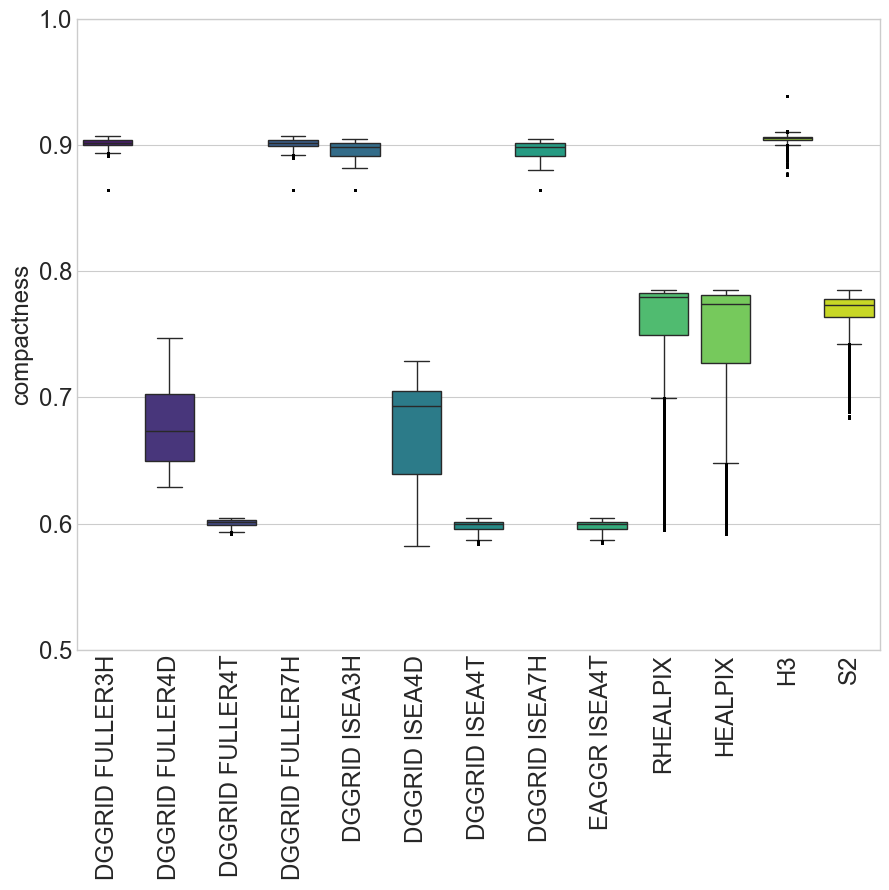

In [63]:
plt.figure(figsize=(9,9))
# fig, ax = plt.subplots(figsize=(10,5))

plt.style.use('seaborn-whitegrid')

#define design of the outliers
outlier_design = dict(marker='o', markerfacecolor='black', markersize=1,
                  linestyle='none', markeredgecolor='black')
#plot the boxplots
chart = sns.boxplot(x='dggs', y="ipq", data=df, palette="viridis", saturation=0.9, showfliers=True, flierprops = outlier_design)

plt.xticks(
    rotation=90, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='xx-large', 
)

plt.xlabel('', fontsize='x-large')

plt.yticks(
    rotation=0, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='xx-large',
)

plt.ylabel('compactness', fontsize='xx-large')

# plt.title("ASTER", fontsize='xx-large')

#set min and max values for y-axis
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.savefig(results_path + "box_plot_compactness.png", bbox_inches="tight",dpi=300)


In [ ]:
# min/max for compactness
# 0.8 - 1.0
g_high = ['DGGRID_FULLER3H', 'DGGRID_FULLER7H', 'DGGRID_ISEA3H','DGGRID_ISEA7H','H3']

# 0.6 - 0.8
g_low = [ 'DGGRID_FULLER4D','DGGRID_ISEA4D',  'RHPIX', 'S2']

# 0.5 - 0.7
g_full_low = [ 'DGGRID_FULLER4T', 'DGGRID_ISEA4T',  'EAGGR_ISEA4T' ]
